In this lab, you will implement PCA based on the power iteration algorithm. You will first compare the running time of your power iteration algorithm with SVD implemented in numpy under a specific problem setup. Then, the implemented PCA algorithm will be applied to the face dataset. You will observe principal components (called eigenfaces) and the reconstructed faces from the low-dimensional representation by PCA. 

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def assert_square(M: np.array) -> np.ndarray:
    assert M.ndim == 2, f"Please provide a matrix. M.ndim={M.ndim}"
    assert M.shape[0] == M.shape[1], f"Please provide a square matrix. M.shape={M.shape}"
    return M

def assert_matrix(M: np.array) -> np.ndarray:
    assert M.ndim == 2, f"Please provide a matrix. M.ndim={M.ndim}"
    return M

In [3]:
def power_iteration(M: np.ndarray,
                    threshold: float = 1e-6,
                    verbose: bool = True):
    # Here, you will implement the power iteration algorithm for approximating the
    # largest eigenvalue "l" and the corresponding eigenvector "b" of an input
    # matrix "M". 
    # Your iteration should continue until |b^{t+1}-b^{t}|<="threshold".

    # The below indicates input/output of power_iteration function.
    # Input 
    # M: square matrix
    # threshold: some small positive number for measuring the convergece (as in the
    #            lecture note)
    # Output
    # l: the largest eigenvalue of "M"
    # b: the eigenvector corresponding to "l" 
    # i: total number of iterations that you used
    M = assert_square(M)
    n = M.shape[0]
    # Initialize
    # bb: b_before, ba: b_after
    bb, ba = np.zeros(n), None
    bb[0] = 1
    lb = 1
    i, diff = 0, np.inf
    while diff > threshold:
        _ba = np.dot(M, bb)
        ba = _ba / np.linalg.norm(_ba)
        la = np.dot(ba.T, np.dot(M, ba))
        # I used eigenvalue ratio for convergence flag
        # since l2-distance between before/after eigenvectors
        # diverges with opposite sign of one other
        # diff = np.linalg.norm(ba - bb, ord=None)
        diff = np.abs(la - lb) / lb
        if verbose:
            print(f"Iterating {i} times. Diff: {diff}. value l: {la}")
        bb = ba
        i += 1
        lb = la
    l = lb
    b = ba
    if verbose:
        print("Power Iteration Result")
        print(f"For given matrix M: {M}")
        print(f"Largest eigenvalue l: {l}")
        print(f"Eigenvector corresponding b: {b}")
        print(f"Total number of iterations i: {i}")
    return l, b, i

def eigh_power_iteration(M: np.ndarray,
                         iteration: int = None,
                         threshold: float = 1e-6,
                         verbose: bool = False):
    assert M.ndim == 2, f"Please provide a matrix. Given M.ndim={M.ndim}"
    assert M.shape[0] == M.shape[1], f"Please provide a square matrix. Given M.shape={M.shape}"
    n = iteration or M.shape[0]
    
    eigval, eigvec = [], []
    while len(eigvec) <= n:
        l, b, _ = power_iteration(M, threshold=threshold, verbose=verbose)
        eigval.append(l)
        eigvec.append(b)
        M = M - l * np.outer(b, b)
        if len(eigvec) >= n:
            break
    eigval = np.array(eigval)
    eigvec = np.array(eigvec).T
    return eigval, eigvec

In [4]:
def get_gt_eigh(M: np.array):
    """ For sanity check """
    M = assert_square(M)
    eigval, eigvec = np.linalg.eigh(M)
    idx = np.argmax(eigval)
    l = eigval[idx]
    b = eigvec[:, idx]
    return l, b

In [5]:
A = np.array(([1, 2, 3], [4, 5, 6]))
M = A.T @ A
print(M)

l, b, i = power_iteration(M=M, verbose=True)
gt_l, gt_b = get_gt_eigh(M=M)

# np.isclose(l, gt_l), np.isclose(np.abs(b), np.abs(gt_b))

[[17 22 27]
 [22 29 36]
 [27 36 45]]
Iterating 0 times. Diff: 89.38881491344874. value l: 90.38881491344874
Iterating 1 times. Diff: 0.00015330445178862688. value l: 90.40267192116687
Iterating 2 times. Diff: 6.692950947542458e-09. value l: 90.40267252622752
Power Iteration Result
For given matrix M: [[17 22 27]
 [22 29 36]
 [27 36 45]]
Largest eigenvalue l: 90.40267252622752
Eigenvector corresponding b: [0.42866757 0.56630698 0.70394639]
Total number of iterations i: 3


In [6]:
"""TODO: implement the following function."""
def my_svd(M: np.ndarray,
           k: int,
           threshold: float = 1e-10,
           verbose: bool = False):
    # Here, you will implement SVD computing top-"k" singular values and 
    # corresponding left/right singular vectors using your power iteration algorithm 
    # (i.e., the power_iteration function you coded above).

    # The below indicates input/output of power_iteration function.
    # Input
    # M: matrix of size n x m (possibly non-square)
    # threshold: some small positive number for the internal power iteration
    # Output
    # U: n x k matrix whose i-th column is the left singular vector corresponding
    #    to the i-th largest singular value
    # S: k x k diagonal matrix whose diagonal entries are top-"k" singular values in 
    #    the descending order
    # V: m x k matrix whose i-th column is the right singular vector corresponding
    #    to the i-th largest singular value
    # Note that USV^T will be the best rank-"k" approximation of "M".
    # i.e., if k=rank("M"), "M"=USV^T

    # Caution: If n <= m, then use MM^T for the power iteration and use M^T M
    #          otherwise; this is for efficient computation. This implies that you 
    #          should compute the left or right singular vectors using the power 
    #          iteration depending on whether n <= m or not.
    M = assert_matrix(M)
    n, m = M.shape
    rank = min(n, m)
    k = min(rank, k)
    if n <= m:
      _M = np.dot(M, M.T) # (n, n)
      S2, U = eigh_power_iteration(_M, iteration=k, threshold=threshold, verbose=verbose)
      S_inv = np.reciprocal(np.sqrt(S2)) * np.eye(S2.shape[0])
      # M = US(V.T), V.T = S^-1 * U^-1 * M
      V = np.dot(np.dot(S_inv, U.T), M).T
    else:
      _M = np.dot(M.T, M) # (m, m)
      S2, V = eigh_power_iteration(_M, iteration=k, threshold=threshold, verbose=verbose)
      S_inv = np.reciprocal(np.sqrt(S2)) * np.eye(S2.shape[0])
      # M = US(V.T), U = M * V * S^-1
      U = np.dot(np.dot(M, V), S_inv)
    S = np.sqrt(S2)
    return U, S, V

In [7]:
u, s, v = my_svd(A, k=2)
u, s, v

(array([[ 0.38631771,  0.92236551],
        [ 0.92236578, -0.38631834]]),
 array([9.508032  , 0.77286964]),
 array([[ 0.42866713, -0.80596754],
        [ 0.56630692, -0.11238721],
        [ 0.7039467 ,  0.58119312]]))

In [8]:
u, s, vT = np.linalg.svd(A, full_matrices=False)
u, s, vT.T

(array([[-0.3863177 , -0.92236578],
        [-0.92236578,  0.3863177 ]]),
 array([9.508032  , 0.77286964]),
 array([[-0.42866713,  0.80596391],
        [-0.56630692,  0.11238241],
        [-0.7039467 , -0.58119908]]))

In [9]:
"""TODO: implement the following function."""
def my_pca(M, k, threshold=1e-10):
    # Here, you will implement PCA using "k" principal componenets using "my_SVD"
    # you just coded.

    # The below indicates input/output of power_iteration function.
    # Input
    # M: matrix of size n x m (n = dimension of data, m = number of data, i.e.,
    #    each column of "M" denotes a single data)
    # threshold: some small positive number for the internal power iteration
    # Output
    # mu: n x 1 column vector that is an average of all data
    # U: n x k matrix whose i-th column is the i-th principal component of "M"
    # B: k x m matrix whose i-th column is the "k"-dimensional approximation of the
    #    i-th column of "M", i.e., this corresponds to beta in the lecture note
    mu = M.mean(axis=1) # (n,)
    M_mean = (M.T - mu).T # n, m
    U, S, V = my_svd(M=M_mean, k=k, threshold=threshold)
    B = np.dot(U.T, M_mean)
    return mu, U, B

In [10]:
# Let's compare the running time of my_svd with k=5 and svd implemented in 
# numpy.
t_svd = np.zeros(20)
t_pi = np.zeros(20)

for i in range(20):
  M = np.random.rand((i+1) * 500, 100)

  t1 = time.time()
  _, _, _ = np.linalg.svd(M)
  t2 = time.time()

  t_svd[i] = t2 - t1

  t1 = time.time()
  _, _, _ = my_svd(M, 5, verbose=False)
  t2 = time.time()

  t_pi[i] = t2 - t1

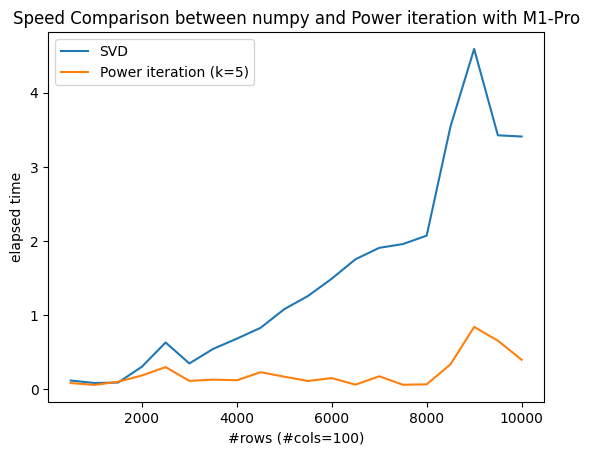

In [11]:
# Plot the running time.
plt.plot(np.arange(500, 10001, 500), t_svd)
plt.plot(np.arange(500, 10001, 500), t_pi)
plt.ylabel('elapsed time')
plt.xlabel('#rows (#cols=100)')
plt.legend(['SVD', 'Power iteration (k=5)'])
plt.title("Speed Comparison between numpy and Power iteration with M1-Pro")
plt.show()

In [12]:
""" TODO: verify the correctness of your my_svd with np.linalg.svd """
# Use "M = np.random.rand(20, 20)" for the test matrix
# Use "k = 5" for my_svd
# Print the following:
# Frobenius norm of (U_k by my_svd - U_k by np.linalg.svd)
# Frobenius norm of (V_k by my_svd - V_k by np.linalg.svd)
# Frobenius norm of (S_k by my_svd - S_k by np.linalg.svd)
M = np.random.rand(20, 20)
k = 5

# To print above quantities, you may transform the output of np.linalg.svd so
# that the "presentation" of U, S, V generated by np.linalg.svd is identical to
# that of my_svd
u, s, vT = np.linalg.svd(M, full_matrices=False)
u, s, vT = u[:, :k], s[:k], vT[:, :k]
u_, s_, vT_ = my_svd(M, k=k)

# e.g., singular vectors are stored in columns of U, V and S is a diagonal 
# matrix in my_svd, but np.linalg.svd generate outputs in a slightly different
# form
sgn = np.sign(u[:, 0]) * np.sign(u_[:, 0])
sgn = np.array([sgn for _ in range(k)]).T
print(f"Compare U: diff: {np.linalg.norm(u - (sgn * u_))}")
print(f"Compare S: diff: {np.linalg.norm(s - s_)}")
sgn = np.sign(vT[:, 0]) * np.sign(vT_[:, 0])
sgn = np.array([sgn for _ in range(k)]).T
print(f"Compare V: diff: {np.linalg.norm(vT - (sgn * vT_))}")

Compare U: diff: 2.000000002564368
Compare S: diff: 5.548275728982363e-10
Compare V: diff: 2.71647704325421


In [13]:
# Import dataset used for eigenface.
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70)

n_samples, h, w = lfw_people.images.shape

print(lfw_people.images.shape)

# Some hyperparameters
n_pc = 200 # number of principal components
threshold = 1e-12 # error bound for your power iteration

(1288, 62, 47)


In [14]:
# This function will help you to visualize images.
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

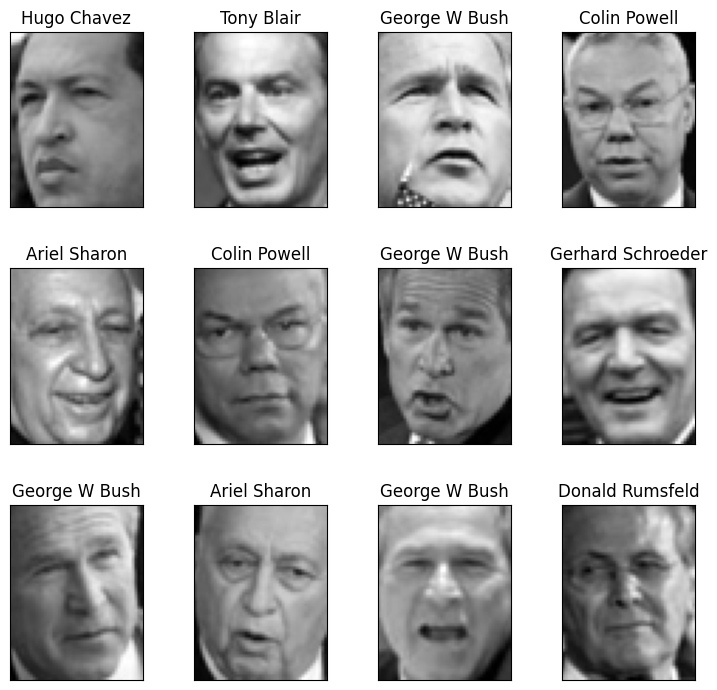

In [15]:
# Let's see some images in the dataset.
X = lfw_people.data
n_features = X.shape[1]
X.shape

y = lfw_people.target
target_names = lfw_people.target_names
target_names = [target_names[y[i]] for i in range(y.shape[0])]

plot_gallery(X, target_names, h, w)

In [16]:
# Run your pca code for this dataset.
# Caution: "X" contains each images in its row, but an input matrix of your PCA 
#          should have data in its column. Hence, we transpose "X".
mu, E, B = my_pca(X.transpose(), n_pc)

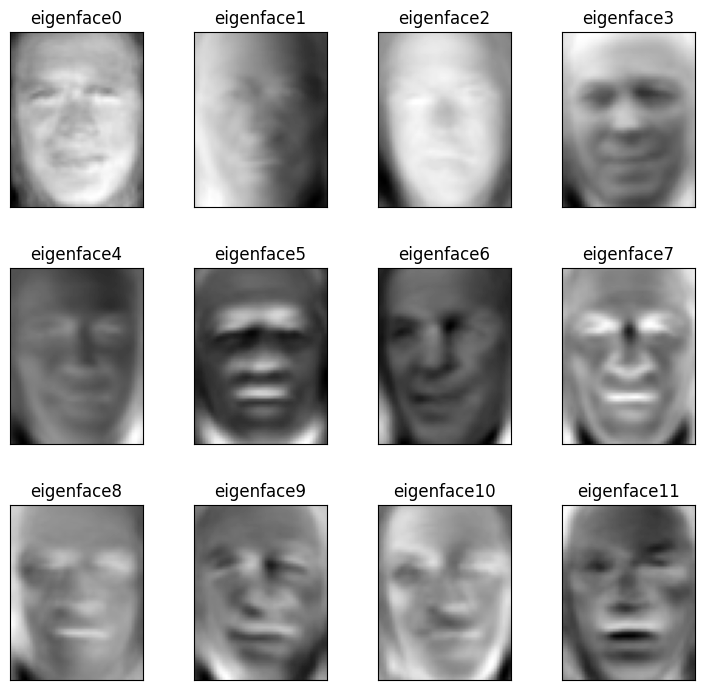

In [17]:
"""TODO: Show images visualizing first 12 eigenfaces (as in the second slide of 
the title "Example: eigenfaces")."""
num_plots = 12
names = [f"eigenface{i}" for i in range(num_plots)]
plot_gallery(E[:, :num_plots].T, names, h, w)

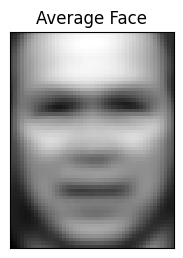

In [18]:
"""TODO: Show images visualizing the average face (as in the first slide of the 
title "Example: eigenfaces")."""
plot_gallery(mu[None, :], titles=["Average Face"], h=h, w=w, n_row=1, n_col=1)

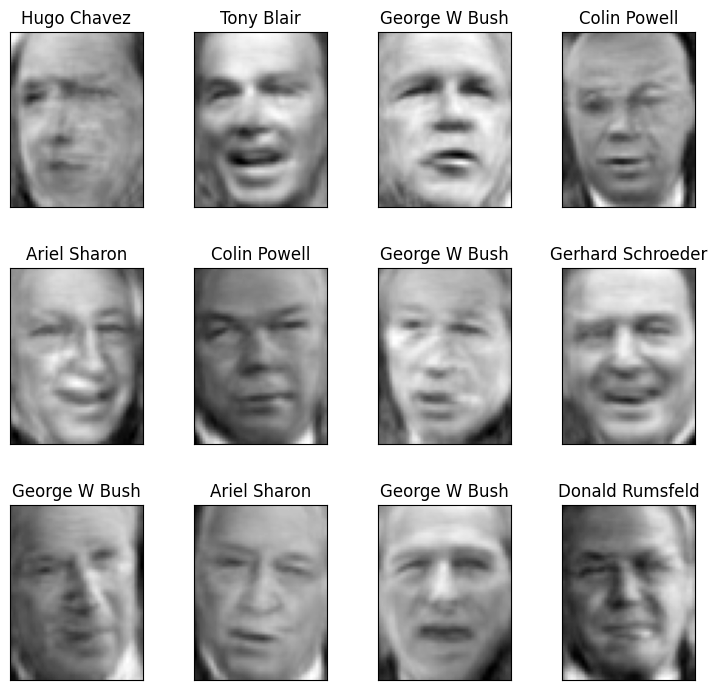

In [19]:
"""TODO: Show reconstructed images using 100 principal components (as in the 
slide of the title "Example: reconstruction (k = 100)")."""
# mu, E, B = my_pca(X.transpose(), 100)
num_plots = 12

_B = E[:, :100].T @ X.T
recon = E[:, :100] @ _B
plot_gallery(recon[:, :num_plots].T, target_names, h, w)